# Extrapolation: HVAC Number of Units

### Importing Packages

In [1]:
import pandas as pd
import numpy as np

import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Importing Simulation and HVAC Data

In [2]:
# Import simulation data
simdata = pd.read_csv("MidPackage_RetrofitResults.csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdata.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdata, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
#merged.head()

# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]

# Renaming some columns
merged = merged.rename(columns={"building type": "building_type", 
                                "year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"] = merged["annual_water"]/merged["floor_area"]

Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


### Importing EBEWE Data

In [3]:
EBEWE_buildings = pd.read_csv("Building_Data.csv") 
EBEWE_buildings = EBEWE_buildings.replace('Not Available',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace('',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace(' ',np.NaN)

# Keeping only unqiue buidling IDs
unique = EBEWE_buildings.drop_duplicates('BUILDING.ID') 

# Renaming some columns
unique = unique.rename(columns={"YEAR.BUILT": "year_built", 
                                "GROSS.BUILDING.FLOOR.AREA": "floor_area", 
                                "SITE.EUI": "site_eui",
                                "TOTAL.WATER.USE": "annual_water"})
# Changing units
unique["annual_water"] = (unique["annual_water"]*1000)/unique['floor_area']

unique.shape

(11724, 36)

## 1. Multi-Family

In [4]:
# Selecting only multi-family housing
regdata1 = merged[(merged["building_type"] == "Multi Family House")]
regdata1.shape

(118, 110)

In [5]:
regdata1 = regdata1[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]

# Adding year_built indicators
regdata1["seventies"] = 0
regdata1.loc[(regdata1['year_built'] < 1980), 'seventies'] = 1
regdata1["eighties"] = 0
regdata1.loc[(regdata1['year_built'] >= 1980) & (regdata1['year_built'] < 1990), 'eighties'] = 1
regdata1["nineties"] = 0
regdata1.loc[(regdata1['year_built'] >= 1990) & (regdata1['year_built'] < 2000), 'ninties'] = 1
regdata1["twothou"] = 0
regdata1.loc[(regdata1['year_built'] > 2000), 'twothou'] = 1

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(regdata1[["floor_area","site_eui","annual_water"]])
regdata1[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata1[["floor_area","site_eui","annual_water"]])

regdata1.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,seventies,eighties,nineties,ninties,twothou
3,48,1971,0.099798,0.463820,0.165269,1,0,0,NaN,0
9,64,1969,0.096850,0.475176,0.217759,1,0,0,NaN,0
11,75,1971,0.156731,0.351933,0.214793,1,0,0,NaN,0
23,39,1986,0.058442,0.405358,0.178111,0,1,0,NaN,0
25,15,1986,0.014625,0.653063,0.409638,0,1,0,NaN,0


### Regression Model

In [6]:
# Regression model
res1 = smf.ols('number_of_HVAC_units ~ floor_area + np.power(floor_area,2) -1', data=regdata1).fit()
print(res1.summary())

                                  OLS Regression Results                                 
Dep. Variable:     number_of_HVAC_units   R-squared (uncentered):                   0.945
Model:                              OLS   Adj. R-squared (uncentered):              0.944
Method:                   Least Squares   F-statistic:                              994.8
Date:                  Thu, 25 Mar 2021   Prob (F-statistic):                    9.59e-74
Time:                          14:49:43   Log-Likelihood:                         -569.57
No. Observations:                   118   AIC:                                      1143.
Df Residuals:                       116   BIC:                                      1149.
Df Model:                             2                                                  
Covariance Type:              nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

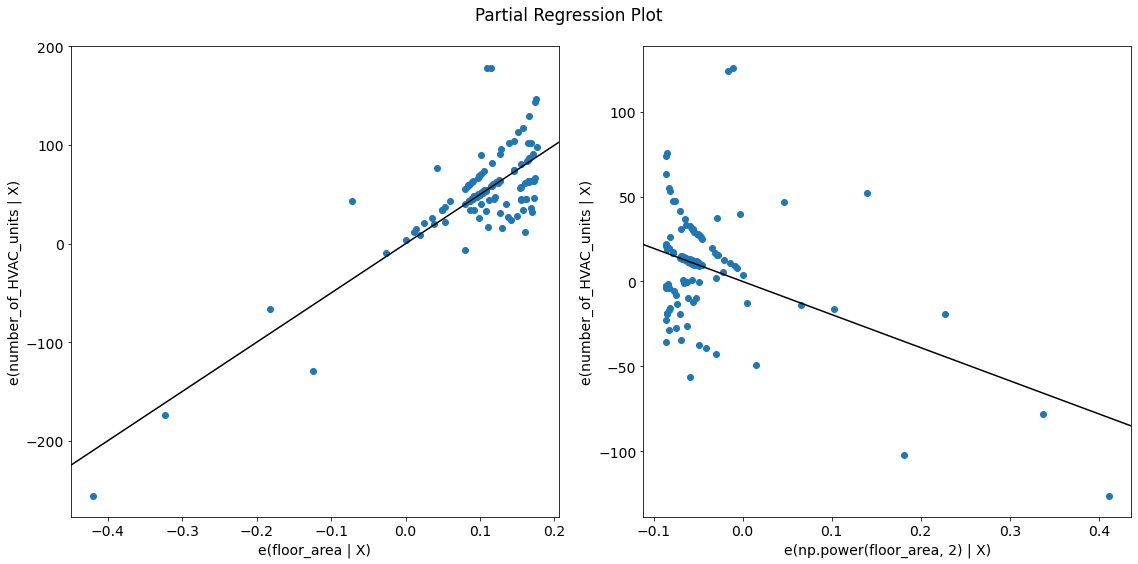

In [7]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res1)
fig.tight_layout(pad=1.0)

In [8]:
#fig = plt.figure(figsize=(12,8))
#fig = sm.graphics.plot_regress_exog(res, 'floor_area', fig=fig)

(-100.0, 500.0)

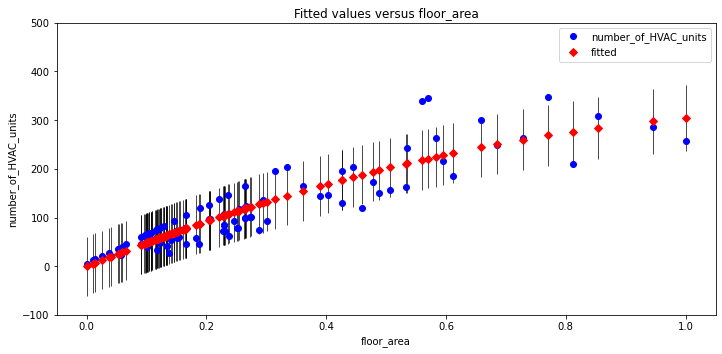

In [60]:
plt.rc("figure", figsize=(10,5))
plt.rc("font", size=10)
fig = sm.graphics.plot_fit(res1, "floor_area")
fig.tight_layout(pad=1.0)
plt.ylim(-100, 500)


### Extrapolating to the EBEWE Open Data

In [10]:
# Select only medium multi-family 
multi_medium = unique[(unique["PROPERTY.TYPE"]=="Multifamily Housing")]
#(unique["LADBS.Building.Category"]=="50,000 to 99,999")
#multi_medium_selection = multi_medium[(multi_medium["YEAR.BUILT"] < 1990) & 
#                                      (multi_medium["YEAR.BUILT"] > 1970) & 
#                                      (multi_medium["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
#                                      (multi_medium["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
multi_medium.shape

(2146, 36)

In [11]:
# Selecting regression x_variables
xvariables1 = multi_medium[["BUILDING.ID", "year_built", "floor_area"]]

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables1[["floor_area"]])
xvariables1[["floor_area"]] = scaler.transform(xvariables1[["floor_area"]])
xvariables1 = xvariables1.drop(columns=["year_built"])

In [44]:
# Predicting # of HVAC Units
xvariables1['predicted_HVAC_units'] = res1.predict(xvariables1[["floor_area"]])
pd.set_option('display.max_rows', 500)
xvariables1['predicted_HVAC_units'] = xvariables1['predicted_HVAC_units'].apply(np.ceil)
xvariables1

,BUILDING.ID,floor_area,predicted_HVAC_units
1,474608916272,0.005545,3.0
5,471068915912,0.014394,8.0
32,475197914051,0.008329,5.0
34,474880915329,0.007088,4.0
42,473333914129,0.009724,5.0
...,...,...,...
40274,383291888609,0.008183,5.0
40278,440648884069,0.011035,6.0
40372,999000000227,0.043070,22.0
40522,403609884896,0.009939,5.0


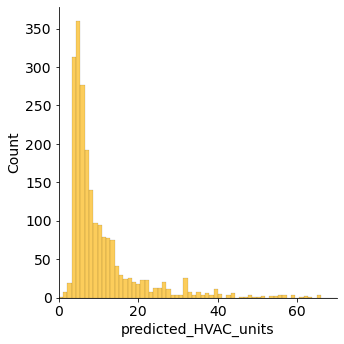

In [45]:
import seaborn as sns
sns.displot(xvariables1, x="predicted_HVAC_units", color="#fcbd24")
plt.xlim(0, 70)
plt.show()

## 2. Offices

In [14]:
# Selecting only multi-family housing
regdata2 = merged[(merged["building_type"] == "Small Office") | 
                  (merged["building_type"] == "Medium Office") | 
                  (merged["building_type"] == "Large Office")]
regdata2.shape

(117, 110)

In [15]:
# Subset dataframe
regdata2 = regdata2[["number_of_HVAC_units","year_built","floor_area","site_eui","annual_water"]]

# Get Year built indicators
regdata2["pre1970"] = 0
regdata2.loc[(regdata2['year_built'] < 1970), 'pre1970'] = 1
regdata2["in1970s"] = 0
regdata2.loc[(regdata2['year_built'] >= 1970) & (regdata2['year_built'] < 1980), 'in1970s'] = 1
regdata2["in1980s"] = 0
regdata2.loc[(regdata2['year_built'] >= 1980) & (regdata2['year_built'] < 1990), 'in1980s'] = 1
regdata2["post1990"] = 0
regdata2.loc[(regdata2['year_built'] > 1990), 'post1990'] = 1

# Scale contious variables
scaler = MinMaxScaler()
scaler.fit(regdata2[["floor_area","site_eui","annual_water"]])
regdata2[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata2[["floor_area","site_eui","annual_water"]])

regdata2.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,pre1970,in1970s,in1980s,post1990
1,1,1984,0.129802,0.424684,0.804878,0,0,1,0
5,1,1981,0.059266,0.513085,0.865854,0,0,1,0
7,3,1984,0.026750,0.078551,0.780488,0,0,1,0
13,1,1980,0.046135,0.555209,0.853659,0,0,1,0
15,3,1985,0.039085,0.069488,0.829268,0,0,1,0


In [16]:
#simdata = merged[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]
x = regdata2.drop(columns=["number_of_HVAC_units", "year_built"])
y = regdata2["number_of_HVAC_units"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train,y_train)
neigh.score(X_test, y_test)

0.7692307692307693

In [18]:
# Select only medium multi-family 
e_offices = unique[(unique["PROPERTY.TYPE"]=="Office")]
#(unique["LADBS.Building.Category"]=="50,000 to 99,999")
#e_offices = e_offices[(e_offices["YEAR.BUILT"] < 1990) & 
#                                      (e_offices["YEAR.BUILT"] > 1970) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
e_offices.shape

(556, 36)

In [19]:
# Selecting regression x_variables
xvariables2 = e_offices[["BUILDING.ID", "year_built", "floor_area", "annual_water", "site_eui"]]

# Add indicator variables as abvove
# Get Year built indicators
xvariables2["pre1970"] = 0
xvariables2.loc[(xvariables2['year_built'] < 1970), 'pre1970'] = 1
xvariables2["in1970s"] = 0
xvariables2.loc[(xvariables2['year_built'] >= 1970) & (xvariables2['year_built'] < 1980), 'in1970s'] = 1
xvariables2["in1980s"] = 0
xvariables2.loc[(xvariables2['year_built'] >= 1980) & (xvariables2['year_built'] < 1990), 'in1980s'] = 1
xvariables2["post1990"] = 0
xvariables2.loc[(xvariables2['year_built'] > 1990), 'post1990'] = 1 

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables2[["floor_area","site_eui","annual_water"]])
xvariables2[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables2[["floor_area","site_eui","annual_water"]])
xvariables2 = xvariables2.drop(columns=["year_built"])

xvariables2 = xvariables2.dropna()

In [20]:
xvariables2['predicted_HVAC_units'] = neigh.predict(xvariables2[['floor_area', 'site_eui', 'annual_water', 'pre1970',
       'in1970s', 'in1980s', 'post1990']])

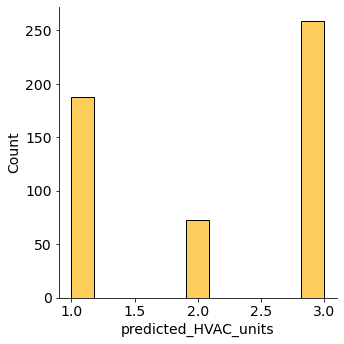

In [46]:
import seaborn as sns
sns.displot(xvariables2, x="predicted_HVAC_units", color="#fcbd24")
plt.show()

# 3. Retail

In [22]:
# Selecting only multi-family housing
retail = merged[(merged["building_type"] == "Small Retail") | 
                 (merged["building_type"] == "Medium Retail") | 
                 (merged["building_type"] == "Large Retail")]
retail.shape

(8, 110)

In [36]:
regdata3 = retail[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]

# Get Year built indicators
regdata3["pre1970"] = 0
regdata3.loc[(regdata3['year_built'] < 1970), 'pre1970'] = 1
regdata3["in1970s"] = 0
regdata3.loc[(regdata3['year_built'] >= 1970) & (regdata3['year_built'] < 1980), 'in1970s'] = 1
regdata3["in1980s"] = 0
regdata3.loc[(regdata3['year_built'] >= 1980) & (regdata3['year_built'] < 1990), 'in1980s'] = 1
regdata3["post1990"] = 0
regdata3.loc[(regdata3['year_built'] > 1990), 'post1990'] = 1

# Scale contious variables
scaler = MinMaxScaler()
scaler.fit(regdata3[["floor_area","site_eui","annual_water"]])
regdata3[["floor_area","site_eui","annual_water"]] = scaler.transform(regdata3[["floor_area","site_eui","annual_water"]])

regdata3.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,pre1970,in1970s,in1980s,post1990
109,1,1989,0.812663,0.068204,0.999919,0,0,1,0
207,2,1969,0.002166,1.000000,0.000808,1,0,0,0
255,2,1989,0.450261,0.000000,0.999758,0,0,1,0
293,2,1988,0.000000,0.802666,0.000000,0,0,1,0
353,1,1966,0.210197,0.330205,1.000000,1,0,0,0


In [37]:
# Regression model
res3 = smf.ols('number_of_HVAC_units ~ floor_area + site_eui + annual_water -1', data=regdata3).fit()
print(res3.summary())

                                  OLS Regression Results                                 
Dep. Variable:     number_of_HVAC_units   R-squared (uncentered):                   0.800
Model:                              OLS   Adj. R-squared (uncentered):              0.680
Method:                   Least Squares   F-statistic:                              6.668
Date:                  Thu, 25 Mar 2021   Prob (F-statistic):                      0.0337
Time:                          14:52:32   Log-Likelihood:                         -8.5782
No. Observations:                     8   AIC:                                      23.16
Df Residuals:                         5   BIC:                                      23.39
Df Model:                             3                                                  
Covariance Type:              nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------

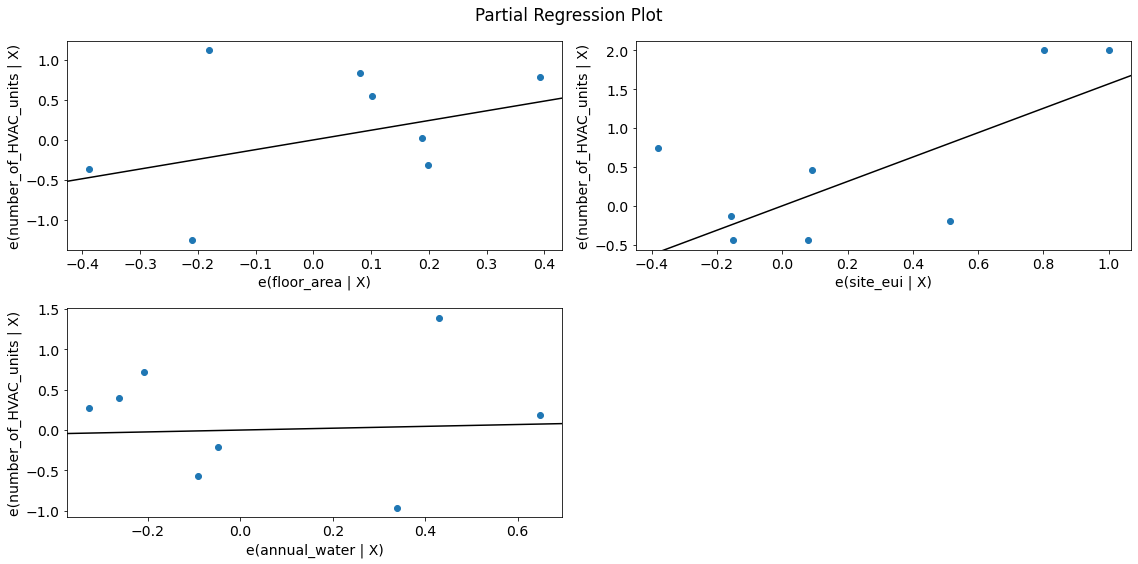

In [38]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res3)
fig.tight_layout(pad=1.0)

In [39]:
# Select only medium multi-family 
e_retail = unique[(unique["PROPERTY.TYPE"]=="Retail Store")]
#(unique["LADBS.Building.Category"]=="50,000 to 99,999")
#e_offices = e_offices[(e_offices["YEAR.BUILT"] < 1990) & 
#                                      (e_offices["YEAR.BUILT"] > 1970) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
#                                      (e_offices["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
e_retail.shape

(89, 36)

In [40]:
# Selecting regression x_variables
xvariables3 = e_retail[["BUILDING.ID", "year_built", "floor_area", "annual_water", "site_eui"]]

# Add indicator variables as abvove
# Get Year built indicators
xvariables3["pre1970"] = 0
xvariables3.loc[(xvariables3['year_built'] < 1970), 'pre1970'] = 1
xvariables3["in1970s"] = 0
xvariables3.loc[(xvariables3['year_built'] >= 1970) & (xvariables3['year_built'] < 1980), 'in1970s'] = 1
xvariables3["in1980s"] = 0
xvariables3.loc[(xvariables3['year_built'] >= 1980) & (xvariables3['year_built'] < 1990), 'in1980s'] = 1
xvariables3["post1990"] = 0
xvariables3.loc[(xvariables3['year_built'] > 1990), 'post1990'] = 1 

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables3[["floor_area","site_eui","annual_water"]])
xvariables3[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables3[["floor_area","site_eui","annual_water"]])
xvariables3 = xvariables3.drop(columns=["year_built"])

xvariables3 = xvariables3.dropna()

In [41]:
#xvariables3['predicted_HVAC_units'] = neigh.predict(xvariables3[['floor_area', 'site_eui', 'annual_water', 'pre1970',
#       'in1970s', 'in1980s', 'post1990']])
# Predicting # of HVAC Units
xvariables3['predicted_HVAC_units'] = res3.predict(xvariables3[["floor_area","site_eui","annual_water"]])
pd.set_option('display.max_rows', 100)
xvariables3['predicted_HVAC_units'] = xvariables3['predicted_HVAC_units'].apply(np.ceil)
xvariables3

,BUILDING.ID,floor_area,annual_water,site_eui,pre1970,in1970s,in1980s,post1990,predicted_HVAC_units
79,478669911672,0.050694,4.193554e-04,0.253938,0,0,0,1,1.0
165,466703917206,0.092956,1.097259e-03,0.637232,0,0,1,0,2.0
410,999000000286,0.707218,1.341781e-08,0.254893,0,0,0,1,2.0
414,999000000128,0.154143,7.308931e-04,0.269212,0,0,0,1,1.0
1847,381005916882,0.249032,6.572772e-04,0.496420,1,0,0,0,2.0
2439,394040910048,0.945753,2.468930e-04,0.166110,0,0,0,1,2.0
3133,392323906596,0.276581,3.302131e-04,0.205251,0,0,0,1,1.0
3134,389347907548,0.064808,2.222090e-04,0.063962,1,0,0,0,1.0
5534,438112897550,0.077606,5.804366e-06,0.044391,0,1,0,0,1.0
5929,444128896966,0.385225,2.928920e-06,0.383771,1,0,0,0,2.0


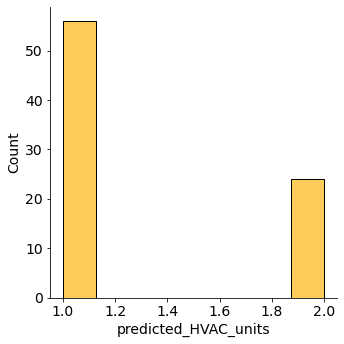

In [43]:
import seaborn as sns
sns.displot(xvariables3, x="predicted_HVAC_units", color="#fcbd24")
plt.show()

## Saving Data

In [47]:
# Combine all property types
hvac_unit_data = pd.concat([xvariables1[["BUILDING.ID", "predicted_HVAC_units"]], 
                        xvariables2[["BUILDING.ID", "predicted_HVAC_units"]],
                        xvariables3[["BUILDING.ID", "predicted_HVAC_units"]]])
# Drop missing values
hvac_unit_data = hvac_unit_data.dropna()
# Ineger
hvac_unit_data['predicted_HVAC_units'] = hvac_unit_data['predicted_HVAC_units'].apply(int)

In [50]:
hvac_unit_data[hvac_unit_data['predicted_HVAC_units'] == 0]

,BUILDING.ID,predicted_HVAC_units
4148,419162907688,0


In [51]:
hvac_unit_data.to_csv("hvac_unit_data.csv", index=False)